This notebook contains evaluation of adaptive samples created by attack on logit, called logit matching attack.

In [3]:
import os
import numpy as np
import torch 
import torch.nn as nn
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt 
import numpy as np 
from captum.attr import *
import quantus
import gc

In [6]:
data_path = '/data/virtual environments/adv detection by robustness/adv_detection/Adaptive attacks/adaptive_attack_images_cifar/srelu/attack both ig and model/16255.npz' 

In [7]:
npobj = np.load(data_path)

In [8]:
use_cuda=True
device = torch.device("cuda" if use_cuda else "cpu")

In [9]:
keys = npobj.files
print(keys)

['adaptive_images', 'adaptive_labels', 'benign_images', 'benign_labels', 'pgd_images', 'pgd_labels']


In [143]:
npobj = np.load(data_path)
adaptive_image = npobj['a_images']
adaptive_label = npobj['a_labels']
ben_image = npobj['b_images']
ben_label = npobj['b_labels']

In [144]:
#load cifar model
from util.model_utils2 import resnet50

def load_model(path):
    model = resnet50()
    ckpt_dict = torch.load(path, lambda storage, loc: storage)
    model.load_state_dict(ckpt_dict)
    model.to('cuda')
    model.train(False)
    return model

modelpath = "/data/virtual environments/adv detection by robustness/adv_detection/Adaptive attacks/Models/CIFAR10/resnet50/cifar.ckpt"
model = load_model(modelpath)
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

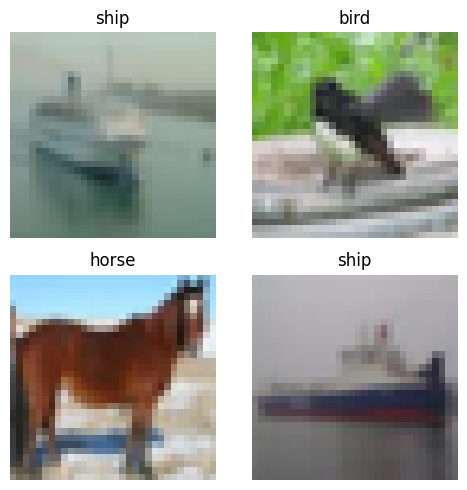

In [145]:
# Define the class names for CIFAR
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the images
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

for i, ax in enumerate(axes.flatten()):
    # Access the image and label at the current index
    image = np.transpose(ben_image[i], (1, 2, 0))  # Transpose to (height, width, channels)
    label = ben_label[i]

    # Plot the image
    ax.imshow(image)
    ax.set_title(class_names[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

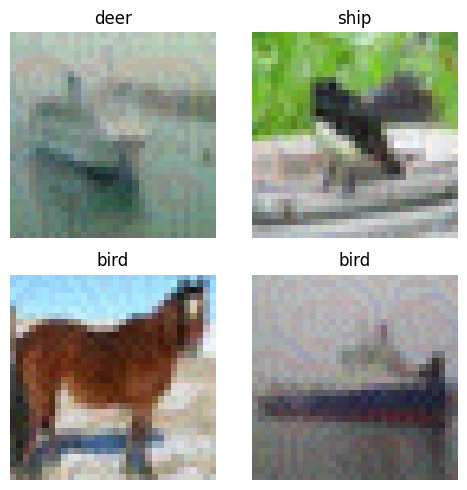

In [146]:
# Define the class names for CIFAR
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the images
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

for i, ax in enumerate(axes.flatten()):
    # Access the image and label at the current index
    image = np.transpose(adaptive_image[i], (1, 2, 0))  # Transpose to (height, width, channels)
    label = adaptive_label[i]

    # Plot the image
    ax.imshow(image)
    ax.set_title(class_names[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [112]:
#compute benign attribution 
images, labels = torch.from_numpy(ben_image), torch.from_numpy(ben_label)
images, labels = images[0:5], labels[0:5]
images, labels = images.to(device), labels.to(device)
intgrad1 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=images, target=labels, baselines=torch.zeros_like(images)).sum(axis=1).cpu().numpy())

In [113]:
# #compute pgd attribution 
# images, labels = torch.from_numpy(pgd_image), torch.from_numpy(pgd_label)
# images, labels = images[0:5], labels[0:5]
# images, labels = images.to(device), labels.to(device)
# intgrad2 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=images, target=labels, baselines=torch.zeros_like(images)).sum(axis=1).cpu().numpy())

In [11]:
#compute adaptive attack images attribution 
images, labels = torch.from_numpy(adaptive_image), torch.from_numpy(adaptive_label)
images, labels = images[0:5], labels[0:5]
images, labels = images.to(device), labels.to(device)
intgrad3 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=images, target=labels, baselines=torch.zeros_like(images)).sum(axis=1).cpu().numpy())

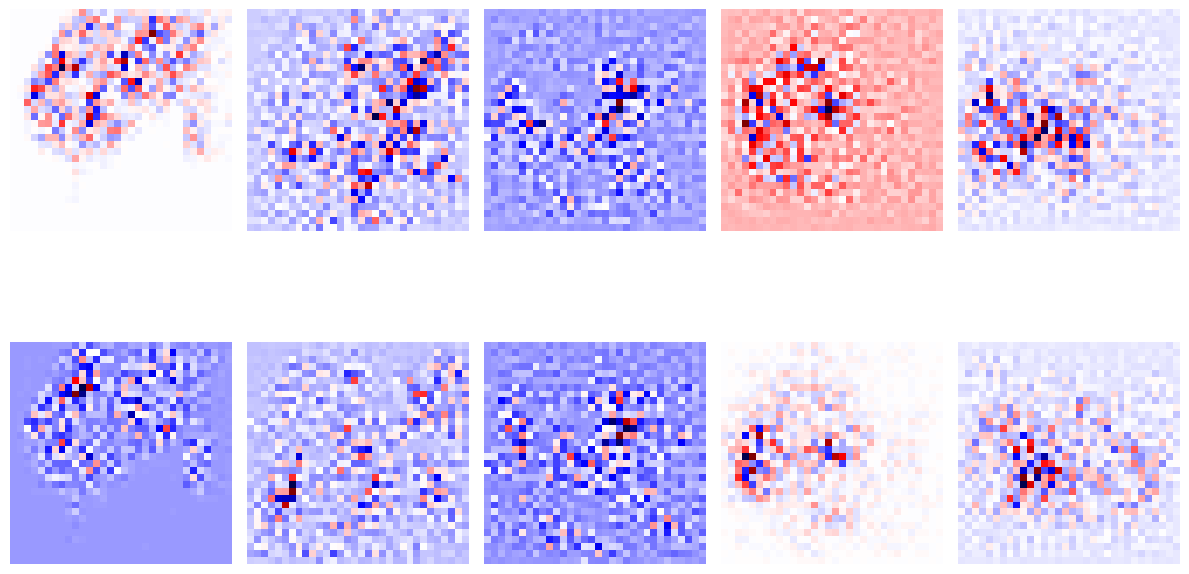

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have intgrad1, intgrad2, and intgrad3 batches of shape (15, height, width, channels)
#intgrad1 = np.random.randn(15, height, width, channels)
#intgrad2 = np.random.randn(15, height, width, channels)
#intgrad3 = np.random.randn(15, height, width, channels)

fig, axes = plt.subplots(2, 5, figsize=(12, 8))

for i, ax in enumerate(axes[0]):
    image1 = np.moveaxis((intgrad1[i]), 0, -1)
    ax.imshow(image1, cmap="seismic")
    ax.axis('off')

# for i, ax in enumerate(axes[1]):
#     image2 = np.moveaxis((intgrad2[i]), 0, -1)
#     ax.imshow(image2, cmap="seismic")
#     ax.axis('off')

for i, ax in enumerate(axes[1]):
    image3 = np.moveaxis((intgrad3[i]), 0, -1)
    ax.imshow(image3, cmap="seismic")
    ax.axis('off')

plt.tight_layout()
plt.show()


# Distortion measure

In [147]:
def calculate_distortion(image1, image2):
    
    img1 = image1.flatten().astype(float)
    img2 = image2.flatten().astype(float)
    
    score = np.linalg.norm(img1-img2)
    
    return score

In [148]:
pgd_=[]
adap =[]
for i in range(0, 20):
    img1 = adaptive_image[i]
    #img2 = pgd_image[i]
    img3 = ben_image[i]

    adap.append(calculate_distortion(img1, img3))
    #pgd_.append(calculate_distortion(img2, img3))
    
#print(np.average(pgd_))
print(np.average(adap))

1.407574023954466


# Detection rate

Compute the attribution sensitivition, prediction sensitivity and input squeeze sensitivity and then report AUC based on our previous learned threshold!

In [149]:
import pandas as pd

In [150]:
def make_noise(x_batch, y_batch, spread):
    new_x_batch = []
    for x in x_batch:
        x = x.data.cpu().numpy()
        stdev = spread * (np.max(x)-np.min(x))
        noise = np.random.normal(0, stdev, x.shape).astype(np.float32)
        x_plus_noise = x + noise
        x_plus_noise = np.clip(x_plus_noise, 0, 1)
        x_plus_noise = torch.from_numpy(x_plus_noise).cpu()
        new_x_batch.append(x_plus_noise)
    new_batch = torch.stack(new_x_batch).to(device)
    return new_batch

In [151]:
normal_model = model 


In [152]:
def compute_metrics(adaptive_image, adaptive_label, normal_model): 
    
    print("Computing metrics for {} for PGD")
    
    #attribution robustness
    attribution_gaussian1 = []
    attribution_gaussian2 = []
    attribution_gaussian3 = []
    
    #logit robustness
    logit_gaussian1 = []
    logit_gaussian2 = []
    logit_gaussian3 = []
    
    images, labels = torch.from_numpy(adaptive_image), torch.from_numpy(adaptive_label)
    #images, labels = images.to(device), labels.to(device)
    
    end = len(adaptive_label)
    
    for i in range(0, end, 2):
        
        images_adv, y_pred_adv = images[i:i+2], labels[i:i+2]
        images_adv, y_pred_adv = images_adv.to(device), y_pred_adv.to(device)
        
        x_logits = normal_model(images_adv)
        gc.collect()
        torch.cuda.empty_cache()
        
        #approach: attribution and logit robustness
        a_batch = quantus.explain(
            model=normal_model, inputs=images_adv, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        gaussian_noisy_images_1 = make_noise(images_adv, y_pred_adv, spread = 0.05)
        gaussian_logits_1 = normal_model(gaussian_noisy_images_1)
        gaussian_noisy_images_2 = make_noise(images_adv, y_pred_adv, spread = 0.10)
        gaussian_logits_2 = normal_model(gaussian_noisy_images_2)
        gaussian_noisy_images_3 = make_noise(images_adv, y_pred_adv, spread = 0.15)
        gaussian_logits_3 = normal_model(gaussian_noisy_images_3)
        
        diff1 = torch.norm(x_logits-gaussian_logits_1,p=1, dim=1) 
        diff2 = torch.norm(x_logits-gaussian_logits_2,p=1, dim=1) 
        diff3 = torch.norm(x_logits-gaussian_logits_3,p=1, dim=1) 
        
        logit_gaussian1.extend(diff1.detach().cpu().numpy())
        logit_gaussian2.extend(diff2.detach().cpu().numpy())
        logit_gaussian3.extend(diff3.detach().cpu().numpy())
        
        
        a_batch_gaussian1 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_1, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian2 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_2, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian3 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_3, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        for a, b in zip(a_batch, a_batch_gaussian1):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian1.append(c)
            
        for a, b in zip(a_batch, a_batch_gaussian2):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian2.append(c)
        
        for a, b in zip(a_batch, a_batch_gaussian3):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian3.append(c)
        
        
    df = pd.DataFrame([
            
            attribution_gaussian1,
            attribution_gaussian2,
            attribution_gaussian3,
            logit_gaussian1,
            logit_gaussian2,
            logit_gaussian3], index = [
            "Gaussian1 attribution", 
            "Gaussian2 attribution", 
            "Gaussian3 attribution", 
            "Gaussian1 logit robusntess",
            "Gaussian2 logit robusntess",
            "Gaussian3 logit robusntess",
                    ])
            
    path = "adaptive_CIFAR_PGD_logitmatch.csv"
    df.to_csv(path)

In [153]:
compute_metrics(ben_image, ben_label, normal_model)

Computing metrics for {} for PGD


/data/virtual environments/adv detection by robustness/adv_detection/lib/python3.8/site-packages/quantus/functions/explanation_func.py:85: UserWarning: Using quantus 'explain' function as an explainer without specifying 'method' (string) in kwargs will produce a vanilla 'Gradient' explanation.

  warnings.warn(
/data/virtual environments/adv detection by robustness/adv_detection/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [154]:
compute_metrics(adaptive_image, adaptive_label, normal_model)

Computing metrics for {} for PGD


In [155]:
def compute_TPR(adv1, a, b, adv2, c, d): 
    TN=0
    FN=0
    FP = 0 
    TP=0
    
    for value1, value2 in zip(adv1, adv2): 
        if value1<a or value1>b:
            TP += 1
        else:
            if value2<c or value2>d:
                TP+=1
            else: 
                FN+=1
    
    return (TP/(TP+FN))*100

In [156]:
def compute_FPR(ap2a, k, l, ap2b, m, n): 
    TN=0
    FN=0
    FP=0 
    TP=0
    
    for value6, value7 in zip(ap2a,ap2b):
        if value6<k or value6>l:
            FP +=1
        else:
            if value7<m or value7>n:
                FP +=1

    return (FP/(len(ap2a)))*100

In [157]:
import sklearn
from sklearn.metrics import roc_auc_score

In [158]:
df_cifar = pd.read_csv("adaptive_CIFAR_Benign_logitmatch.csv")

In [159]:
df_cifar

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,398,399,400,401,402,403,404,405,406,407
0,Gaussian1 attribution,8952.22700,4302.40230,3923.23140,6729.31450,3928.55520,3778.52640,3332.64360,5795.51600,5028.33600,...,5343.84700,5482.35800,4222.57500,4618.19630,4113.13960,8130.14400,6492.2710,5203.29100,6855.52000,5280.38500
1,Gaussian2 attribution,5745.27730,3801.51540,3185.94210,5254.45850,3282.68460,3789.97600,3160.17200,5441.17100,3671.48580,...,3976.20460,5055.44500,3892.85180,3988.75150,3557.31980,6827.19140,3841.3425,4666.97360,6344.78700,4995.81000
2,Gaussian3 attribution,5389.51000,3635.74120,3141.91100,4856.64940,3273.00340,3632.67820,3034.55270,5383.10000,3453.77150,...,3553.26150,4490.82130,3451.04900,3817.32350,3366.33420,6526.36000,3377.2450,4781.80860,6257.47660,4863.22400
3,Gaussian1 logit robusntess,256.77410,212.07968,164.47638,159.95572,195.04904,180.52094,198.08466,222.77344,189.85878,...,153.92989,238.46762,126.69058,160.06280,171.93011,223.28558,782.0584,161.86813,175.41122,153.34381
4,Gaussian2 logit robusntess,314.88165,267.83264,228.51747,268.35114,253.92581,288.03802,309.94458,236.07343,265.45880,...,249.48961,279.63712,279.29373,238.43360,231.87746,301.01306,831.9783,252.01482,224.03076,251.19878
5,Gaussian3 logit robusntess,326.67233,282.62408,271.73755,247.00974,248.64177,293.79480,331.08590,253.72230,267.68274,...,254.68169,292.27080,310.75037,254.98853,283.67880,281.69910,845.6012,216.10309,241.82935,257.68150


In [160]:
attr_gaussian3 = df_cifar.iloc[2].values.flatten().tolist()[1:]
logit_gaussian3 = df_cifar.iloc[5].values.flatten().tolist()[1:]

In [161]:
#logitgaussian3
k=[44,64,76, 86, 96, 106, 126, 150, 200, 400]
l=[405,405,405,405,405,405,405,405,405,405, 405]

#attrgaussian3
m=[2200,2800,3100, 3500, 4000, 4500, 5000, 5500, 6000, 8000]
n=[8800,8800,8800, 8800,8800,8800, 8800,8800,8800, 8800]

fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
print(fpr_results)

[0.02941176470588235, 0.0857843137254902, 0.16176470588235292, 0.3112745098039216, 0.49754901960784315, 0.696078431372549, 0.8602941176470589, 0.9387254901960784, 0.9730392156862745, 1.0]


In [162]:
df_pgd_eps1 = pd.read_csv("adaptive_CIFAR_PGD_logitmatch.csv")

In [163]:
attr_gaussian3_eps1 = df_pgd_eps1.iloc[2].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_pgd_eps1.iloc[5].values.flatten().tolist()[1:]

In [164]:
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
print(sklearn.metrics.auc(fpr_results, tpr_results))

0.8036824485891918
